In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from utils import *

In [2]:
'''
params options

na_data will fill missing data with 'unknown', delete missing data or do nothing
input options are...
    * 'fill'
    * 'drop'
    * False

drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
input options are...
    * False
    * or any integer

embed creates 50x1 embedding vectors for color and breed.
    download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
    * True
    * False

sample_dict controls stratified sampling
    * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
    * train_size: a fraction of data you want for the training data
    * validate_size: a fraction of data you want for the validate data
    * test_size: a fraction of data you want for the test data

num_buckets how many buckets to break up length of stay into for model training
    creates new column Days_in_Shelter_Label
    * input is a integer
'''

params = {
        'na_data': 'fill',
        'drop_outlier_days': 300,
        'embed':True,
        'num_buckets':5,
        'sample_dict':
            {
            'stratify_col':'Type',
            'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
            }
        }
train_df, validate_df, test_df = load_df(params)
df = pd.concat([train_df, validate_df, test_df], ignore_index=True) # do this if you want to look at all the data still

Date Of Birth is NOT A STRING
Intake Date is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Count is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Size with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'


/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
train_df.to_csv('train.csv',index=False)
validate_df.to_csv('validate.csv',index=False)
test_df.to_csv('test.csv',index=False)

In [4]:
df.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date_Of_Birth',
       'Impound_Number', 'Kennel_Number', 'Animal_ID', 'Intake_Date',
       'Outcome_Date', 'Days_in_Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome_Type', 'Outcome_Subtype', 'Intake_Condition',
       'Outcome_Condition', 'Intake_Jurisdiction', 'Outcome_Jurisdiction',
       'Outcome_Zip_Code', 'Location', 'Multiple_Visit_Count',
       'Age_inDays_at_Income', 'Age_Group', 'Is_Aggressive', 'Has_Name',
       'Is_Fixed', 'Is_Mixed_Breed', 'Is_Multicolor', 'Color_Embedding',
       'Color_Embedding_Cluster', 'Breed_Embedding', 'Breed_Embedding_Cluster',
       'Days_in_Shelter_Label'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25235 entries, 0 to 25234
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Name                     25235 non-null  object        
 1   Type                     25235 non-null  object        
 2   Breed                    25235 non-null  object        
 3   Color                    25235 non-null  object        
 4   Sex                      25235 non-null  object        
 5   Size                     25235 non-null  object        
 6   Date_Of_Birth            25235 non-null  datetime64[ns]
 7   Impound_Number           25235 non-null  object        
 8   Kennel_Number            25235 non-null  object        
 9   Animal_ID                25235 non-null  object        
 10  Intake_Date              25235 non-null  datetime64[ns]
 11  Outcome_Date             25235 non-null  datetime64[ns]
 12  Days_in_Shelter          25235 n

In [6]:
df.describe()

,Date_Of_Birth,Intake_Date,Outcome_Date,Days_in_Shelter,Multiple_Visit_Count,Age_inDays_at_Income,Is_Aggressive,Has_Name,Is_Fixed,Is_Mixed_Breed,Is_Multicolor,Color_Embedding_Cluster,Breed_Embedding_Cluster
count,25235,25235,25235,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000
mean,1991-08-29 21:44:35.284327296,2018-08-17 08:35:37.602536192,2018-09-04 12:09:19.793936896,18.148405,1.334535,9849.452110,0.049257,0.789221,0.633485,0.288686,0.512027,2.220923,1.964533
min,1900-01-01 00:00:00,2013-08-17 00:00:00,2014-01-01 00:00:00,0.000000,1.000000,-1336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-03-26 00:00:00,2016-02-06 00:00:00,2016-02-23 00:00:00,1.000000,1.000000,252.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2014-03-12 00:00:00,2018-04-14 00:00:00,2018-04-28 00:00:00,9.000000,1.000000,1096.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000,2.000000
75%,2017-08-19 00:00:00,2021-02-06 12:00:00,2021-02-23 00:00:00,24.000000,1.000000,4376.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000
max,2024-05-12 00:00:00,2024-05-15 00:00:00,2024-05-16 00:00:00,298.000000,19.000000,45425.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000
std,NaN,NaN,NaN,27.804476,1.036732,17033.272835,0.216408,0.407870,0.481862,0.453161,0.499865,1.114463,1.388583


<Axes: ylabel='Frequency'>

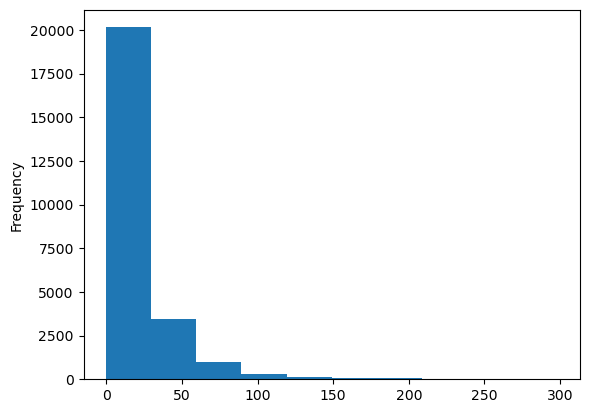

In [7]:
df.Days_in_Shelter.plot.hist()

## Animal Gender

In [8]:
df.Sex.unique()

array(['MALE', 'FEMALE', 'UNKNOWN'], dtype=object)

## Animal Breed

In [9]:
print(f'there are {len(df.Breed.unique())} unique breeds')
cat_breed_count = len(df.Breed[df.Type=='CAT'].unique())
print(f'cat breeds: {cat_breed_count}')
dog_breed_count = len(df.Breed[df.Type=='DOG'].unique())
print(f'dog breeds: {dog_breed_count}')

there are 938 unique breeds
cat breeds: 58
dog breeds: 880


In [10]:
df.Type.value_counts()

Type
DOG    15491
CAT     9744
Name: count, dtype: int64

Text(0.5, 1.0, 'CAT Breeds')

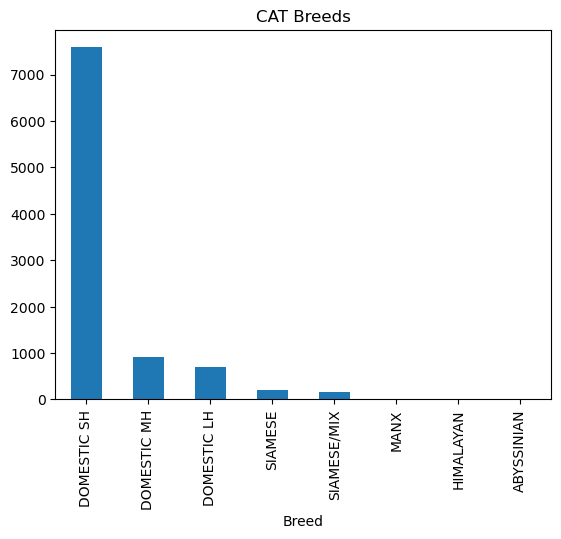

In [11]:
df[df.Type=='CAT'].Breed.value_counts()[0:8].plot.bar()
plt.title('CAT Breeds')

Text(0.5, 1.0, 'DOG Breeds')

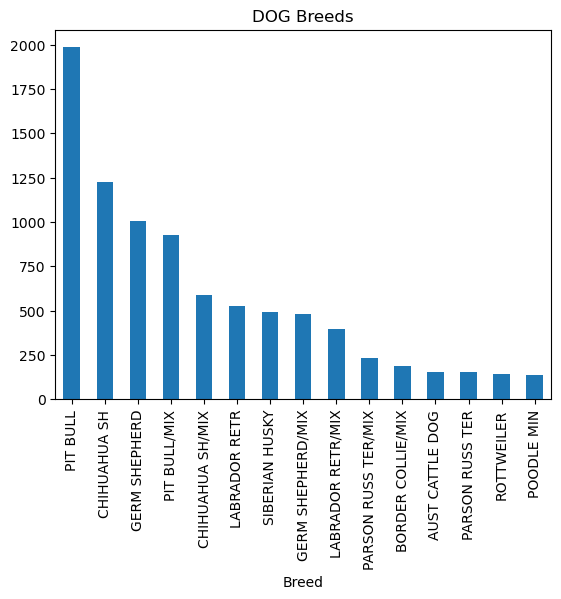

In [12]:
df[df.Type=='DOG'].Breed.value_counts()[0:15].plot.bar()
plt.title('DOG Breeds')

## Animal Type

In [13]:
df.Type.unique()

array(['DOG', 'CAT'], dtype=object)

## Animal Size

Text(0.5, 1.0, 'CAT Sizes')

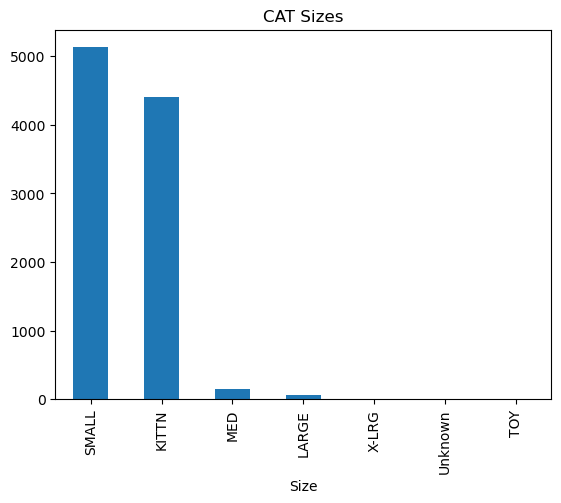

In [14]:
df[df.Type=='CAT'].Size.value_counts().plot.bar()
plt.title('CAT Sizes')

Text(0.5, 1.0, 'DOG Sizes')

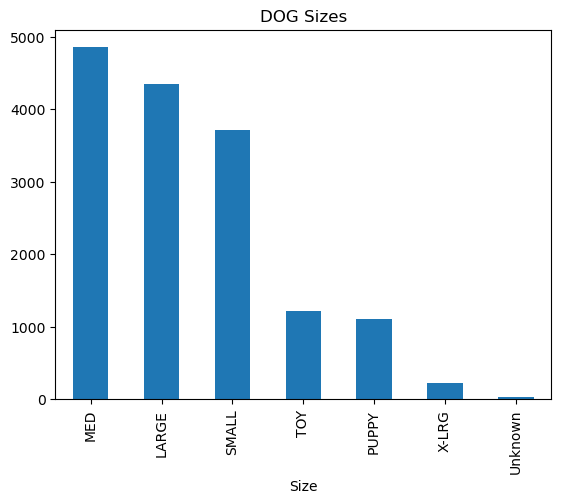

In [15]:
df[df.Type=='DOG'].Size.value_counts().plot.bar()
plt.title('DOG Sizes')

## What colors do we have?

In [16]:
print(f'there are {len(df.Color.unique())} unique colors')
breed_color = len(df.Color[df.Type=='CAT'].unique())
print(f'cat colors: {breed_color}')
breed_color = len(df.Color[df.Type=='DOG'].unique())
print(f'dog colors: {breed_color}')
print()
print(df.Color.value_counts())

there are 322 unique colors
cat colors: 170
dog colors: 211

Color
BLACK/WHITE       2952
BLACK             2423
BRN TABBY         1459
WHITE             1226
BLACK/TAN         1210
                  ... 
CREAM/BLUE PT        1
WHITE/RED TICK       1
BL BRINDLE/TAN       1
RED/CREAM            1
BLONDE               1
Name: count, Length: 322, dtype: int64


Text(0.5, 1.0, 'DOG colors')

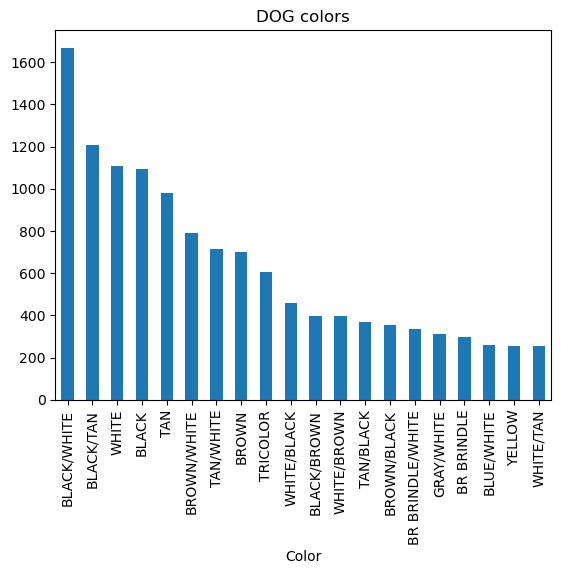

In [17]:
df[df.Type=='DOG'].Color.value_counts()[:20].plot.bar()
plt.title('DOG colors')

Text(0.5, 1.0, 'cat colors')

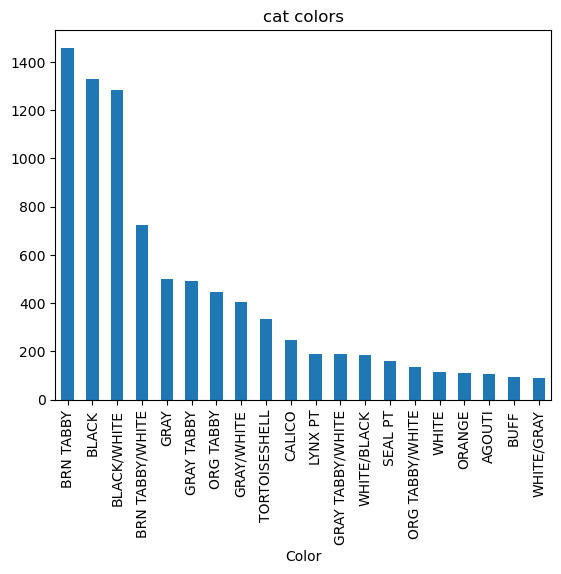

In [18]:
df[df.Type=='CAT'].Color.value_counts()[:20].plot.bar()
plt.title('cat colors')

## Intake Type is skewed

Text(0.5, 1.0, 'intake type')

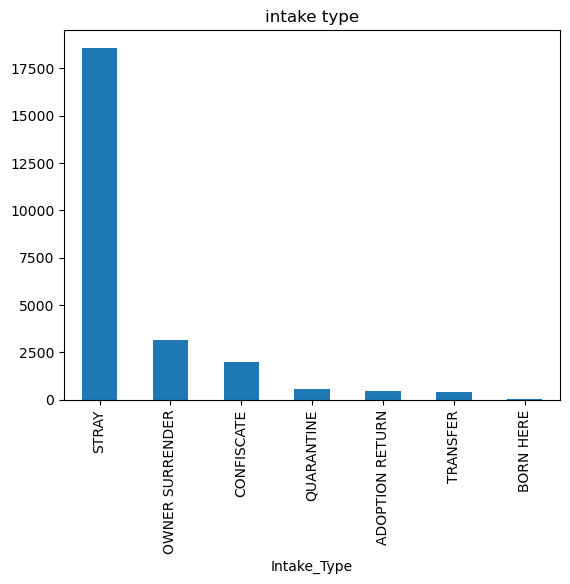

In [19]:
df.Intake_Type.value_counts().plot.bar()
plt.title('intake type')

Text(0.5, 1.0, 'intake subtype')

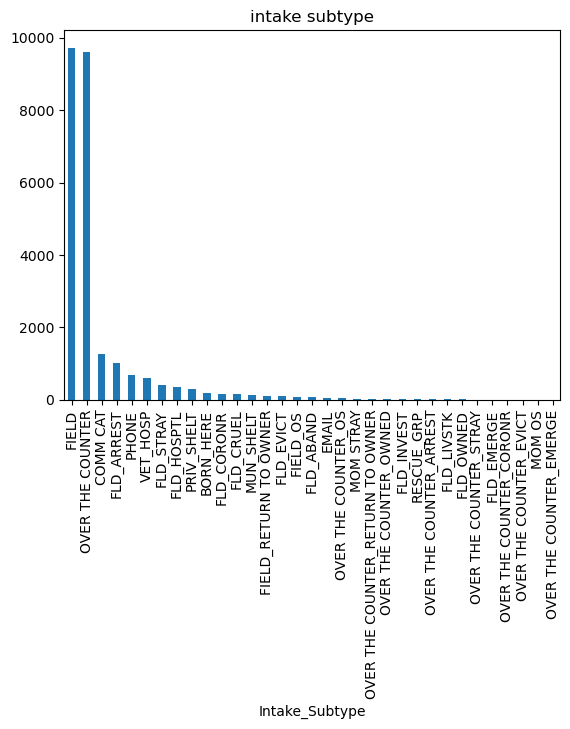

In [20]:
df.Intake_Subtype.value_counts().plot.bar()
plt.title('intake subtype')

## Most animals are not euthanized, but there are still a lot of animals in this category

Text(0.5, 1.0, 'Outcome type')

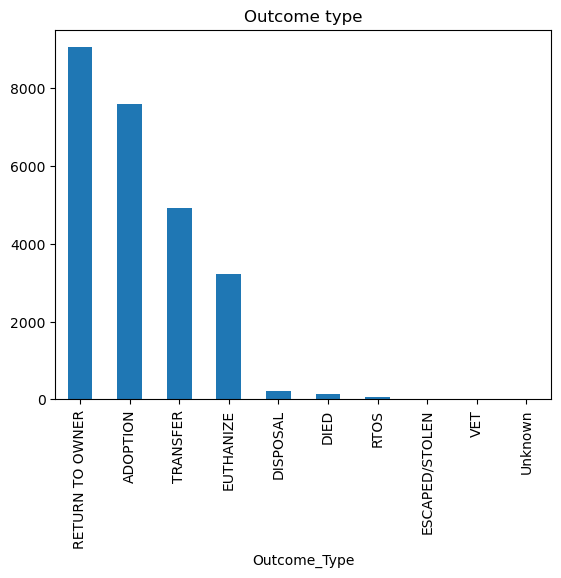

In [21]:
df.Outcome_Type.value_counts().plot.bar()
plt.title('Outcome type')

## outcome subtype has so many options. could be interesting to use NLP here

In [22]:
len(df.Outcome_Subtype.unique())

220

Text(0.5, 1.0, 'Outcome subtype')

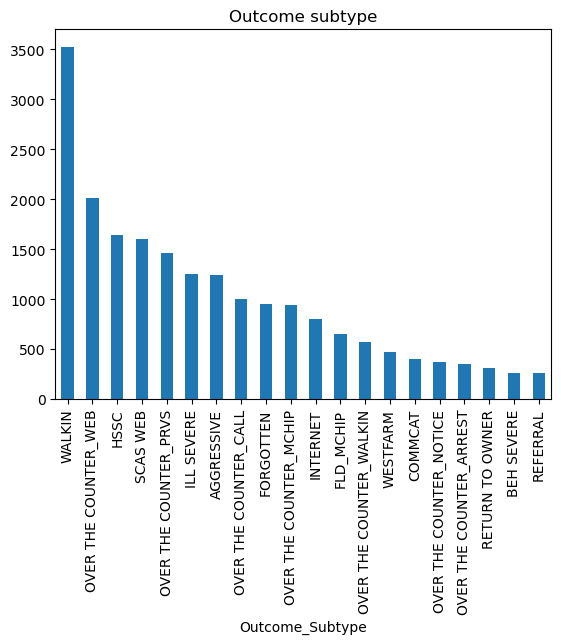

In [23]:
df.Outcome_Subtype.value_counts()[:20].plot.bar()
plt.title('Outcome subtype')

## most animals come in healthy, when is condition be unknown?

Text(0.5, 1.0, 'Intake_Condition')

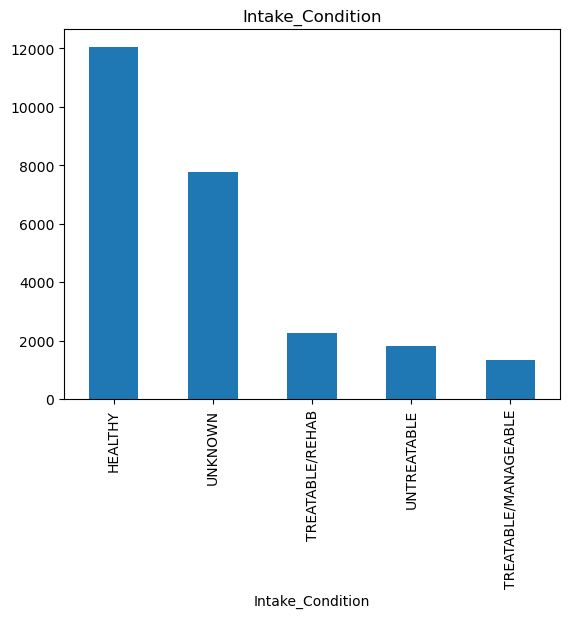

In [24]:
df.Intake_Condition.value_counts()[:20].plot.bar()
plt.title('Intake_Condition')

## it appears going to a shelter usually improves health

what does pending mean?

Text(0.5, 1.0, 'Outcome_Condition')

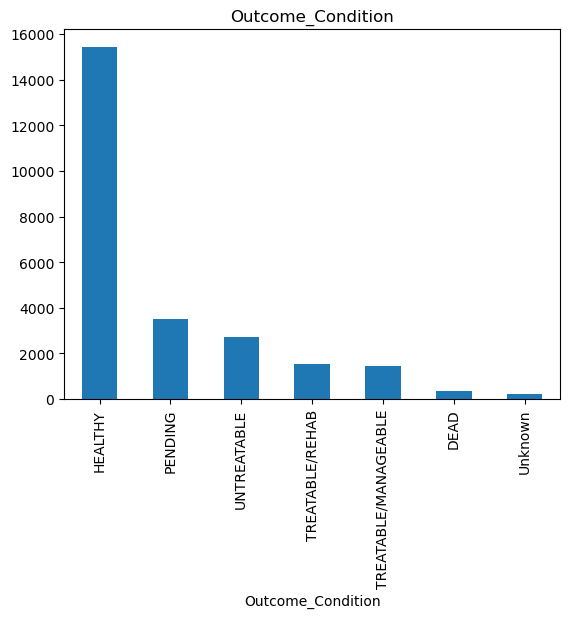

In [25]:
df.Outcome_Condition.value_counts()[:20].plot.bar()
plt.title('Outcome_Condition')

In [26]:
df.Intake_Jurisdiction.unique()

array(['SANTA ROSA', '*ROHNERT PARK', 'COUNTY', '*WINDSOR',
       'OUT OF COUNTY', '*HEALDSBURG', '*SEBASTOPOL', '*PETALUMA',
       '*CLOVERDALE', '*TRIBAL RESV', '*SONOMA', '*COTATI', 'UNKNOWN'],
      dtype=object)

In [27]:
df[df.Outcome_Jurisdiction != df.Intake_Jurisdiction]

,Name,Type,Breed,Color,Sex,Size,Date_Of_Birth,Impound_Number,Kennel_Number,Animal_ID,...,Is_Aggressive,Has_Name,Is_Fixed,Is_Mixed_Breed,Is_Multicolor,Color_Embedding,Color_Embedding_Cluster,Breed_Embedding,Breed_Embedding_Cluster,Days_in_Shelter_Label
1,Unknown,DOG,CHIHUAHUA SH,TAN/WHITE,FEMALE,SMALL,2011-09-11,K23-046033,DA23,A420326,...,0,1,0,0,1,"[-0.52346, 0.562445, -0.68111503, 0.399905, 0....",0,"[0.130645, -0.560145, 0.16823497, 0.5767175, -...",3,1
3,*KODA,DOG,MIN PINSCHER,RED,FEMALE,SMALL,2003-12-10,K14-007233,DA02,A300443,...,0,0,1,0,0,"[-0.12878, 0.8798, -0.60694, 0.12934, 0.5868, ...",3,"[-0.86184, 0.64402, 0.53236, -0.24103001, 0.01...",2,0
5,BILLIE,DOG,PIT BULL,BR BRINDLE/WHITE,FEMALE,LARGE,2014-11-05,K16-018744,DI100,A336649,...,0,1,1,0,1,"[-0.46112666, 0.27985334, -0.19634998, -0.2574...",1,"[0.095295, 0.0053056004, -0.11658999, -0.14415...",0,4
6,GINGER,DOG,LABRADOR RETR/MIX,TAN,FEMALE,MED,2012-05-01,K22-041239,DS60,A411289,...,0,1,1,1,0,"[-0.3604, 0.32364, -0.74983, 0.95101, 0.49193,...",4,"[-0.11674667398134868, -0.008909866757070025, ...",2,4
7,*SPRECKLES,CAT,DOMESTIC SH,BLUE CREAM,FEMALE,SMALL,2022-07-17,K22-043004,LOBBY,A413977,...,0,0,1,0,0,"[-0.59397, 0.68918, -0.74532497, 0.162426, 0.4...",1,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25228,Unknown,CAT,DOMESTIC SH,BRN TABBY,UNKNOWN,KITTN,1900-01-01,K19-033006,RECEIVING,A389498,...,0,1,0,0,0,"[-0.40614, -0.14449, 0.24456999, 0.80013, 0.26...",2,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,0
25231,Unknown,CAT,DOMESTIC SH,BLACK,UNKNOWN,SMALL,1900-01-01,K14-010711,CS06,A311399,...,0,1,0,0,0,"[-0.96256, 0.65329, -0.55152, -0.41065, 0.8022...",3,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,2
25232,Unknown,CAT,DOMESTIC SH,WHITE/BLACK,MALE,SMALL,1900-01-01,K21-039402,COOLER,A406405,...,0,1,0,0,1,"[-0.82454, 0.72727, -0.58195996, -0.280925, 0....",3,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,1
25233,SHYLOW,DOG,CHIHUAHUA SH,BROWN,MALE,TOY,2007-02-28,K14-007702,DA48,A265409,...,0,1,1,0,0,"[-0.88497, 0.71685, -0.40379, -0.10698, 0.8145...",3,"[0.130645, -0.560145, 0.16823497, 0.5767175, -...",3,3


## Thoughts
There are many categories for breed, color and outcome subtype. Perhaps too many. We may need to feature engineer these columns to group similar colors

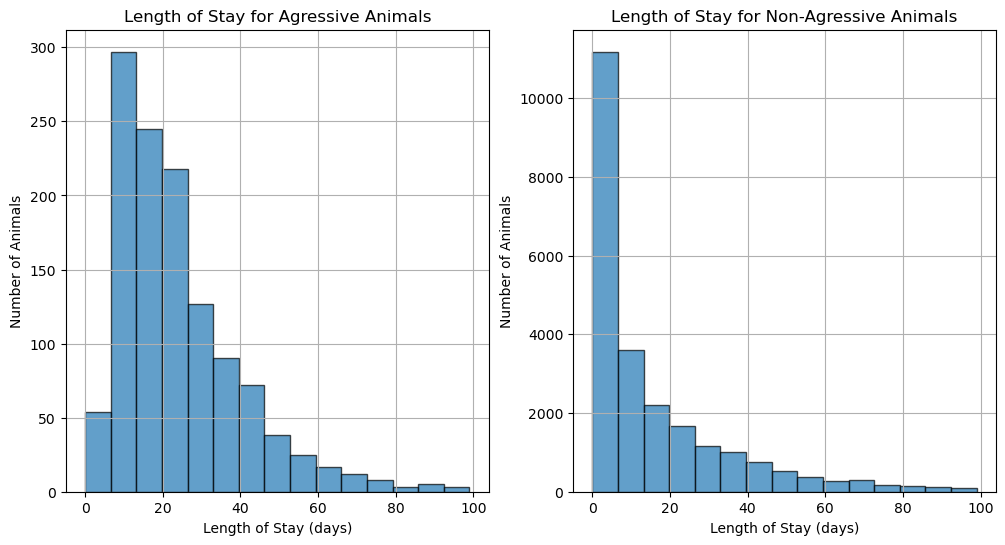

In [28]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
agressive = df[df['Is_Aggressive'] == 1]
not_aggressive = df[df['Is_Aggressive'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(agressive[agressive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Length of Stay for Agressive Animals')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Number of Animals')
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(not_aggressive[not_aggressive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Length of Stay for Non-Agressive Animals')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Number of Animals')
plt.grid(True)


In [29]:
popular_breeds = df.Breed.value_counts().reset_index().head(11)

breed1 = popular_breeds.Breed.iloc[1]
for i in range(popular_breeds.shape[0]):
    breed2 = popular_breeds.Breed.iloc[i]
    vec1 = df[df.Breed==breed1].iloc[0].Breed_Embedding.reshape(1, -1)
    vec2 = df[df.Breed==breed2].iloc[0].Breed_Embedding.reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]

    print(f"Cosine similarity between {breed1} and {breed2}: {similarity}")


Cosine similarity between PIT BULL and DOMESTIC SH: 0.21472840011119843
Cosine similarity between PIT BULL and PIT BULL: 1.0
Cosine similarity between PIT BULL and CHIHUAHUA SH: 0.08315540850162506
Cosine similarity between PIT BULL and GERM SHEPHERD: 0.3103894591331482
Cosine similarity between PIT BULL and PIT BULL/MIX: 0.8793880343437195
Cosine similarity between PIT BULL and DOMESTIC MH: 0.1275845468044281
Cosine similarity between PIT BULL and DOMESTIC LH: 0.23789280652999878
Cosine similarity between PIT BULL and CHIHUAHUA SH/MIX: 0.21361185610294342
Cosine similarity between PIT BULL and LABRADOR RETR: 0.18866603459188988
Cosine similarity between PIT BULL and SIBERIAN HUSKY: 0.17136384546756744
Cosine similarity between PIT BULL and GERM SHEPHERD/MIX: 0.3663058578968048


In [30]:
embeddings = np.array(df.Breed_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['Breed'] = df.Breed
df_embeddings['Cluster'] = clusters

for cluster in df_embeddings['Cluster'].unique():
    popular_breeds = df_embeddings[df_embeddings.Cluster==cluster].Breed.value_counts().reset_index().head(4)
    breed1 = popular_breeds.Breed.iloc[1]
    for i in range(popular_breeds.shape[0]):
        breed2 = popular_breeds.Breed.iloc[i]
        vec1 = df[df.Breed==breed1].iloc[0].Breed_Embedding.reshape(1, -1)
        vec2 = df[df.Breed==breed2].iloc[0].Breed_Embedding.reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)[0][0]

        print(f"Cluster {cluster} Cosine similarity between {breed1} and {breed2}: {similarity}")
    print('')

Cluster 3 Cosine similarity between PIT BULL/MIX and PIT BULL: 0.8793880343437195
Cluster 3 Cosine similarity between PIT BULL/MIX and PIT BULL/MIX: 0.9999999403953552
Cluster 3 Cosine similarity between PIT BULL/MIX and BULL TERRIER: 0.644585371017456
Cluster 3 Cosine similarity between PIT BULL/MIX and GERM SHEPHERD/PIT BULL: 0.7918804287910461

Cluster 2 Cosine similarity between CHIHUAHUA SH/MIX and CHIHUAHUA SH: 0.843735933303833
Cluster 2 Cosine similarity between CHIHUAHUA SH/MIX and CHIHUAHUA SH/MIX: 1.000000238418579
Cluster 2 Cosine similarity between CHIHUAHUA SH/MIX and POMERANIAN: 0.3406563699245453
Cluster 2 Cosine similarity between CHIHUAHUA SH/MIX and POMERANIAN/MIX: 0.6154388189315796

Cluster 1 Cosine similarity between DOMESTIC MH and DOMESTIC SH: 0.8345993161201477
Cluster 1 Cosine similarity between DOMESTIC MH and DOMESTIC MH: 1.0000001192092896
Cluster 1 Cosine similarity between DOMESTIC MH and DOMESTIC LH: 0.6407502293586731
Cluster 1 Cosine similarity between

/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
popular_colors = df.Color.value_counts().reset_index().head(11)

color1 = popular_colors.Color.iloc[1]
for i in range(popular_colors.shape[0]):
    color2 = popular_colors.Color.iloc[i]
    vec1 = df[df.Color==color1].iloc[0].Color_Embedding.reshape(1, -1)
    vec2 = df[df.Color==color2].iloc[0].Color_Embedding.reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]

    print(f"Cosine similarity between {color1} and {color2}: {similarity}")


Cosine similarity between BLACK and BLACK/WHITE: 0.9757598638534546
Cosine similarity between BLACK and BLACK: 0.9999999403953552
Cosine similarity between BLACK and BRN TABBY: 0.09395656734704971
Cosine similarity between BLACK and WHITE: 0.9058136343955994
Cosine similarity between BLACK and BLACK/TAN: 0.8416008353233337
Cosine similarity between BLACK and TAN: 0.35849127173423767
Cosine similarity between BLACK and BROWN/WHITE: 0.8669304847717285
Cosine similarity between BLACK and BROWN: 0.7596039175987244
Cosine similarity between BLACK and BRN TABBY/WHITE: 0.6616023182868958
Cosine similarity between BLACK and TAN/WHITE: 0.7685388922691345
Cosine similarity between BLACK and GRAY/WHITE: 0.8879954814910889
